In [46]:
import os
import io
import shutil
import warnings
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn import CrossEntropyLoss, MSELoss, BCEWithLogitsLoss

from transformers import AutoTokenizer, AutoModel, AutoModelForMaskedLM

from pytorch_pretrained_bert import BertTokenizer, BertConfig, BertAdam, BertForSequenceClassification

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
    auc
)
from sklearn.utils import resample

from keras.models import Sequential, load_model
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D, LSTM, Flatten, SimpleRNN, Dropout, Bidirectional, GRU
from keras.callbacks import ModelCheckpoint, EarlyStopping

from tqdm import tqdm, trange

warnings.filterwarnings("ignore", category=ConvergenceWarning)
os.environ['PYTHONWARNINGS'] = 'ignore'
os.environ['TRANSFORMERS_CACHE'] = 'trans_cache'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ["TOKENIZERS_PARALLELISM"] = "false"
model_name = "allenai/scibert_scivocab_uncased"
cache = 'trans_cache'
models_path = 'models/first_run/Scibert'

train_set = pd.read_csv('data/manual_curation/train.csv')
test_set = pd.read_csv('data/manual_curation/test.csv')

train_labels = train_set["LABEL"].values
validation_labels = test_set["LABEL"].values

train_sents = train_set["SENTENCE"]
validation_sents = test_set["SENTENCE"]

device = torch.device("cpu")

tokenizer_f = AutoTokenizer.from_pretrained(model_name, cache_dir= cache)

model_f = AutoModel.from_pretrained(model_name, cache_dir= cache)

2.15.0


In [2]:
# setting the max length for padding

In [3]:
max_len = 128

tokenized_train_f = train_sents.apply((lambda x: tokenizer_f.encode(x, add_special_tokens=True)))
tokenized_val_f = validation_sents.apply((lambda x: tokenizer_f.encode(x, add_special_tokens=True)))

padded_train_f = np.array([i + [0]*(max_len-len(i)) if len(i) < max_len else i[:max_len] for i in tokenized_train_f.values])
padded_val_f = np.array([i + [0]*(max_len-len(i)) if len(i) < max_len else i[:max_len] for i in tokenized_val_f.values])

attention_mask_train_f = np.where(padded_train_f != 0, 1, 0)
attention_mask_val_f = np.where(padded_val_f != 0, 1, 0)

input_ids_train_f = torch.tensor(padded_train_f)  
input_ids_val_f = torch.tensor(padded_val_f)  

attention_mask_train_f = torch.tensor(attention_mask_train_f)
attention_mask_val_f = torch.tensor(attention_mask_val_f)

with torch.no_grad():
    last_hidden_states_train = model_f(input_ids_train_f, attention_mask=attention_mask_train_f)
    last_hidden_states_val = model_f(input_ids_val_f, attention_mask=attention_mask_val_f)


features_train = last_hidden_states_train[0][:,0,:].numpy()
features_val= last_hidden_states_val[0][:,0,:].numpy()

train_labels_l = torch.tensor(train_labels).long()
validation_labels_l = torch.tensor(validation_labels).long()

In [4]:
# Logistic Regression

In [5]:

# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 500, 1000]
}

lr_clf = LogisticRegression(random_state=42)
# Create a pipeline with scaling and logistic regression

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=lr_clf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=20, error_score="raise")
grid_search.fit(features_train, train_labels_l)

# Output the best hyperparameters and the corresponding accuracy
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy (Cross-Validation):", grid_search.best_score_)

# Evaluate the best model on the validation set
best_lr_model = grid_search.best_estimator_

# Save the best model to a file
joblib.dump(best_lr_model, models_path + '/lr_model.pkl')

# Load the best model
best_lr_model = joblib.load( models_path + '/lr_model.pkl')

lr_pred = best_lr_model.predict(features_val)

print("Classification report on the validation set:")
print(classification_report(validation_labels_l, lr_pred))

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best Parameters: {'C': 0.01, 'max_iter': 500, 'penalty': 'l2', 'solver': 'saga'}
Best Accuracy (Cross-Validation): 0.7782639414082713
Classification report on the validation set:
              precision    recall  f1-score   support

           0       0.80      0.60      0.69       322
           1       0.78      0.91      0.84       511

    accuracy                           0.79       833
   macro avg       0.79      0.75      0.76       833
weighted avg       0.79      0.79      0.78       833



In [6]:
# SVM

In [7]:
# Define the parameter grid for tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10],               
    'gamma': ['scale', 'auto', 0.1, 0.01], 
    'kernel': ['rbf'],                      
    'probability': [True]                  
}

# Initialize the SVM model
svm_clf = SVC(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(svm_clf, param_grid, cv=5, scoring='accuracy', n_jobs=20, verbose=1)

# Fit the model using the training data
grid_search.fit(features_train, train_labels_l)

# Output the best hyperparameters and the best cross-validation accuracy
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy (Cross-Validation):", grid_search.best_score_)

# Train the best model on the entire training set (optional, since GridSearchCV has already done this)
best_svm_model = grid_search.best_estimator_

# Save the best model to a file
joblib.dump(best_svm_model, models_path + '/svm_model.pkl')

# Load the best model
best_svm_model = joblib.load(models_path + '/svm_model.pkl')

# Make predictions using the best model on the validation set
svm_pred = best_svm_model.predict(features_val)

# Print the classification report for the best model
print("Classification report for the best model:")
print(classification_report(validation_labels_l, svm_pred))


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf', 'probability': True}
Best Accuracy (Cross-Validation): 0.7877884143348061
Classification report for the best model:
              precision    recall  f1-score   support

           0       0.81      0.64      0.72       322
           1       0.80      0.91      0.85       511

    accuracy                           0.80       833
   macro avg       0.81      0.77      0.78       833
weighted avg       0.80      0.80      0.80       833



In [8]:
# Random Forest

In [9]:
# Define the parameter grid for Random Forest tuning
param_grid = {
    'n_estimators': [50, 100, 200],               
    'max_depth': [None, 10, 20, 30],               
    'min_samples_split': [2, 5, 10],               
    'min_samples_leaf': [1, 2, 4],                 
    'max_features': ['sqrt', 'log2'],     
    'bootstrap': [True, False]                     
}

# Initialize the Random Forest model
rf_clf = RandomForestClassifier(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(rf_clf, param_grid, cv=5, scoring='accuracy', n_jobs=30, verbose=1)

# Fit the model using the training data
grid_search.fit(features_train, train_labels_l)

# Output the best hyperparameters and the best cross-validation accuracy
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy (Cross-Validation):", grid_search.best_score_)

# Train the best model on the entire training set (optional, since GridSearchCV has already done this)
best_rf_model = grid_search.best_estimator_

# Save the best model to a file
joblib.dump(best_rf_model, models_path + '/rf_model.pkl')

# Load the best model
best_rf_model = joblib.load(models_path + '/rf_model.pkl')

# Make predictions using the best Random Forest model on the validation set
rf_pred = best_rf_model.predict(features_val)

# Print the classification report for the best model
print("Classification report for Random Forest Classifier:")
print(classification_report(validation_labels_l, rf_pred))


Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best Parameters: {'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best Accuracy (Cross-Validation): 0.777495721052422
Classification report for Random Forest Classifier:
              precision    recall  f1-score   support

           0       0.78      0.57      0.66       322
           1       0.77      0.90      0.83       511

    accuracy                           0.77       833
   macro avg       0.77      0.73      0.74       833
weighted avg       0.77      0.77      0.76       833



In [10]:
# reshape features for Deep

In [11]:
train_bert_features = last_hidden_states_train.last_hidden_state
test_bert_features = last_hidden_states_val.last_hidden_state

train_bert_features_reshaped = tf.reshape(train_bert_features, (train_bert_features.shape[0], train_bert_features.shape[1], -1))
test_bert_features_reshaped = tf.reshape(test_bert_features, (test_bert_features.shape[0], test_bert_features.shape[1], -1))

train_bert_features_reshaped = tf.convert_to_tensor(train_bert_features_reshaped, dtype=tf.float32)
train_labels = tf.convert_to_tensor(train_labels, dtype=tf.float32)
test_bert_features_reshaped = tf.convert_to_tensor(test_bert_features_reshaped, dtype=tf.float32)
validation_labels = tf.convert_to_tensor(validation_labels, dtype=tf.float32)

In [12]:
# LSTM

In [13]:
from tensorflow.keras.optimizers.legacy import Adam

num_folds = 5
best_model_losses = []
optimizer = Adam(learning_rate=1e-3)

# Create a DataFrame to store losses for each fold
all_fold_losses = pd.DataFrame(columns=['Fold', 'Train Loss', 'Validation Loss'])

# Create the KFold object
kf = KFold(n_splits=num_folds, shuffle=True)

best_fold_train_loss = []
best_fold_val_loss = []
best_fold = None

# Iterate over the folds
for fold, (train_index, val_index) in enumerate(kf.split(train_bert_features_reshaped, train_labels), 1):
    print(f"Fold {fold}:")

    # Split the data into training and validation sets
    X_train, X_val = np.take(train_bert_features_reshaped, train_index, axis=0), np.take(train_bert_features_reshaped, val_index, axis=0)
    y_train, y_val = np.take(train_labels, train_index, axis=0), np.take(train_labels, val_index, axis=0)

    # Build the LSTM model
    model_lstm = Sequential()
    model_lstm.add(Bidirectional(LSTM(256, return_sequences=True, input_shape=(train_bert_features_reshaped.shape[1],
                                                                               train_bert_features_reshaped.shape[2]), 
                                                                               dropout=0.3, recurrent_dropout=0.3)))
    model_lstm.add(Bidirectional(LSTM(128, return_sequences=False)))
    model_lstm.add(Dropout(0.5))
    model_lstm.add(Dense(64, activation='relu'))
    model_lstm.add(Dense(1, activation='sigmoid'))
    model_lstm.compile(metrics=['accuracy'], optimizer=optimizer, loss='binary_crossentropy')

    # Define the model checkpoint callback
    model_checkpoint = ModelCheckpoint(models_path + '/rest_of_folds/model_lstm_fold_' + str(int(fold)) + '.h5', monitor='val_loss', save_best_only=True)

    # Train the model
    history = model_lstm.fit(
        X_train, y_train, 
        batch_size=64, 
        epochs=20, 
        validation_data=(X_val, y_val), 
        callbacks=[EarlyStopping(patience=3), model_checkpoint]
    )

    # Append the losses of the best model to the list
    best_model_losses.append({
        'Fold': fold,
        'Train Loss': min(history.history['loss']),
        'Validation Loss': min(history.history['val_loss'])
    })

    # Save the training and validation losses for this fold
    fold_losses_df = pd.DataFrame({
        'Epoch': range(1, len(history.history['loss']) + 1),
        'Train Loss': history.history['loss'],
        'Validation Loss': history.history['val_loss']
    })

    # If this fold has the best validation loss, update the tracking variables
    if best_fold is None or min(history.history['val_loss']) < best_model_losses[best_fold - 1]['Validation Loss']:
        best_fold = fold
        best_fold_train_loss = history.history['loss']
        best_fold_val_loss = history.history['val_loss']

    all_fold_losses = pd.concat([all_fold_losses, fold_losses_df.assign(Fold=fold)], ignore_index=True)

# Save all fold losses to a CSV file
all_fold_losses.to_csv(models_path + '/all_fold_losses_lstm.csv', index=False)

# Convert the list of losses to a DataFrame
losses_df = pd.DataFrame(best_model_losses)

# Write the DataFrame to a CSV file
losses_df.to_csv(models_path + '/losses_lstm.csv', index=False)

# Save the train and validation losses of the best fold to a CSV file
best_fold_losses_df = pd.DataFrame({
    'Epoch': range(1, len(best_fold_train_loss) + 1),
    'Train Loss': best_fold_train_loss,
    'Validation Loss': best_fold_val_loss
})
best_fold_losses_df.to_csv(models_path + '/best_fold_lstm_losses.csv', index=False)

# Load the best model
shutil.copyfile(models_path + '/rest_of_folds/model_lstm_fold_' + str(int(best_fold)) + '.h5', models_path + '/model_lstm.h5')
best_lstm_model = load_model(models_path + '/model_lstm.h5')

# Print the summary of the best model
print("Best Model Summary (Fold {}):".format(int(best_fold)))
best_lstm_model.summary()

# Evaluate the best model on the test set
test_pred = np.round(best_lstm_model.predict(test_bert_features_reshaped))
classification_report_test = classification_report(validation_labels, test_pred)

# Print the classification report of the best model on the test set
print("Classification Report - Best Model on Test Set:\n", classification_report_test)


Fold 1:
Epoch 1/20
49/49 [==============================] - 44s 696ms/step - loss: 0.5656 - accuracy: 0.7144 - val_loss: 0.5523 - val_accuracy: 0.7529
Epoch 2/20


/mnt/raid1/eliza/tools/miniconda/envs/ML_bert/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 28s 563ms/step - loss: 0.4875 - accuracy: 0.7775 - val_loss: 0.5020 - val_accuracy: 0.7671
Epoch 3/20
49/49 [==============================] - 31s 634ms/step - loss: 0.4578 - accuracy: 0.7923 - val_loss: 0.4736 - val_accuracy: 0.7709
Epoch 4/20
49/49 [==============================] - 31s 635ms/step - loss: 0.4063 - accuracy: 0.8229 - val_loss: 0.4561 - val_accuracy: 0.7876
Epoch 5/20
49/49 [==============================] - 31s 641ms/step - loss: 0.3577 - accuracy: 0.8442 - val_loss: 0.4469 - val_accuracy: 0.7979
Epoch 6/20
49/49 [==============================] - 31s 636ms/step - loss: 0.3033 - accuracy: 0.8719 - val_loss: 0.5631 - val_accuracy: 0.7349
Epoch 7/20
49/49 [==============================] - 31s 627ms/step - loss: 0.2810 - accuracy: 0.8847 - val_loss: 0.4656 - val_accuracy: 0.8005
Epoch 8/20
49/49 [==============================] - 31s 634ms/step - loss: 0.1976 - accuracy: 0.9221 - val_loss: 0.5510 - val_accuracy: 0.7992
Fold 2:


/tmp/ipykernel_4002579/1908550099.py:68: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_fold_losses = pd.concat([all_fold_losses, fold_losses_df.assign(Fold=fold)], ignore_index=True)


Epoch 1/20
49/49 [==============================] - 43s 680ms/step - loss: 0.6017 - accuracy: 0.6951 - val_loss: 0.5422 - val_accuracy: 0.7375
Epoch 2/20


/mnt/raid1/eliza/tools/miniconda/envs/ML_bert/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 31s 635ms/step - loss: 0.5139 - accuracy: 0.7646 - val_loss: 0.5386 - val_accuracy: 0.7207
Epoch 3/20
49/49 [==============================] - 31s 623ms/step - loss: 0.4922 - accuracy: 0.7756 - val_loss: 0.4931 - val_accuracy: 0.7748
Epoch 4/20
49/49 [==============================] - 25s 509ms/step - loss: 0.4462 - accuracy: 0.7927 - val_loss: 0.4808 - val_accuracy: 0.7928
Epoch 5/20
49/49 [==============================] - 31s 626ms/step - loss: 0.3981 - accuracy: 0.8213 - val_loss: 0.4355 - val_accuracy: 0.8134
Epoch 6/20
49/49 [==============================] - 31s 629ms/step - loss: 0.3561 - accuracy: 0.8432 - val_loss: 0.4110 - val_accuracy: 0.8069
Epoch 7/20
49/49 [==============================] - 31s 630ms/step - loss: 0.3098 - accuracy: 0.8645 - val_loss: 0.4298 - val_accuracy: 0.8057
Epoch 8/20
49/49 [==============================] - 31s 625ms/step - loss: 0.2787 - accuracy: 0.8831 - val_loss: 0.4614 - val_accuracy: 0.8044
Epoch 9/20

/mnt/raid1/eliza/tools/miniconda/envs/ML_bert/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 42s 654ms/step - loss: 0.6287 - accuracy: 0.6668 - val_loss: 0.5243 - val_accuracy: 0.7632
Epoch 2/20
49/49 [==============================] - 31s 629ms/step - loss: 0.5258 - accuracy: 0.7566 - val_loss: 0.5155 - val_accuracy: 0.7568
Epoch 3/20
49/49 [==============================] - 30s 618ms/step - loss: 0.4818 - accuracy: 0.7772 - val_loss: 0.5006 - val_accuracy: 0.7709
Epoch 4/20
49/49 [==============================] - 30s 620ms/step - loss: 0.4510 - accuracy: 0.8033 - val_loss: 0.4749 - val_accuracy: 0.7696
Epoch 5/20
49/49 [==============================] - 30s 618ms/step - loss: 0.4279 - accuracy: 0.8139 - val_loss: 0.4838 - val_accuracy: 0.7967
Epoch 6/20
49/49 [==============================] - 30s 621ms/step - loss: 0.3648 - accuracy: 0.8503 - val_loss: 0.4809 - val_accuracy: 0.7735
Epoch 7/20
49/49 [==============================] - 25s 514ms/step - loss: 0.3414 - accuracy: 0.8599 - val_loss: 0.4680 - val_accuracy: 0.7645
Epoch 8/20

/mnt/raid1/eliza/tools/miniconda/envs/ML_bert/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 41s 657ms/step - loss: 0.6421 - accuracy: 0.6482 - val_loss: 0.6727 - val_accuracy: 0.6147
Epoch 2/20
49/49 [==============================] - 31s 626ms/step - loss: 0.5574 - accuracy: 0.7332 - val_loss: 0.5278 - val_accuracy: 0.7590
Epoch 3/20
49/49 [==============================] - 31s 630ms/step - loss: 0.5088 - accuracy: 0.7679 - val_loss: 0.5015 - val_accuracy: 0.7668
Epoch 4/20
49/49 [==============================] - 25s 515ms/step - loss: 0.4974 - accuracy: 0.7776 - val_loss: 0.4965 - val_accuracy: 0.7590
Epoch 5/20
49/49 [==============================] - 26s 530ms/step - loss: 0.4720 - accuracy: 0.7882 - val_loss: 0.4915 - val_accuracy: 0.7603
Epoch 6/20
49/49 [==============================] - 25s 519ms/step - loss: 0.4476 - accuracy: 0.7985 - val_loss: 0.4990 - val_accuracy: 0.7655
Epoch 7/20
49/49 [==============================] - 26s 521ms/step - loss: 0.4273 - accuracy: 0.8082 - val_loss: 0.4800 - val_accuracy: 0.7719
Epoch 8/20

/mnt/raid1/eliza/tools/miniconda/envs/ML_bert/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 41s 646ms/step - loss: 0.6174 - accuracy: 0.6714 - val_loss: 0.6140 - val_accuracy: 0.7126
Epoch 2/20
49/49 [==============================] - 30s 608ms/step - loss: 0.5350 - accuracy: 0.7547 - val_loss: 0.5472 - val_accuracy: 0.7345
Epoch 3/20
49/49 [==============================] - 30s 609ms/step - loss: 0.5081 - accuracy: 0.7593 - val_loss: 0.4927 - val_accuracy: 0.7745
Epoch 4/20
49/49 [==============================] - 30s 612ms/step - loss: 0.5056 - accuracy: 0.7686 - val_loss: 0.4789 - val_accuracy: 0.7693
Epoch 5/20
49/49 [==============================] - 30s 607ms/step - loss: 0.4710 - accuracy: 0.7815 - val_loss: 0.4941 - val_accuracy: 0.7693
Epoch 6/20
49/49 [==============================] - 30s 611ms/step - loss: 0.4497 - accuracy: 0.7995 - val_loss: 0.4662 - val_accuracy: 0.7809
Epoch 7/20
49/49 [==============================] - 28s 568ms/step - loss: 0.3982 - accuracy: 0.8297 - val_loss: 0.4471 - val_accuracy: 0.7990
Epoch 8/20

In [14]:
best_lstm_model = load_model(models_path + '/model_lstm.h5')
lstm_pred = np.round(best_lstm_model.predict(test_bert_features_reshaped))
print(classification_report(validation_labels, lstm_pred))

27/27 [==============================] - 5s 130ms/step
              precision    recall  f1-score   support

         0.0       0.72      0.83      0.77       322
         1.0       0.88      0.80      0.84       511

    accuracy                           0.81       833
   macro avg       0.80      0.81      0.81       833
weighted avg       0.82      0.81      0.81       833



In [15]:
# CNN

In [16]:

num_folds = 5
best_model_losses = []
optimizer = Adam(learning_rate=1e-3)

# Create a DataFrame to store losses for each fold
all_fold_losses = pd.DataFrame(columns=['Fold', 'Train Loss', 'Validation Loss'])

# Create the KFold object
kf = KFold(n_splits=num_folds, shuffle=True)

best_fold_train_loss = []
best_fold_val_loss = []
best_fold = None

# Iterate over the folds
for fold, (train_index, val_index) in enumerate(kf.split(train_bert_features_reshaped, train_labels), 1):
    print(f"Fold {fold}:")

    # Split the data into training and validation sets
    X_train, X_val = np.take(train_bert_features_reshaped, train_index, axis=0), np.take(train_bert_features_reshaped, val_index, axis=0)
    y_train, y_val = np.take(train_labels, train_index, axis=0), np.take(train_labels, val_index, axis=0)

    # Create the CNN model
    cnn_model = Sequential()
    cnn_model.add(Conv1D(128, kernel_size=3, activation='relu', 
                         input_shape=(train_bert_features_reshaped.shape[1], train_bert_features_reshaped.shape[2])))
    cnn_model.add(MaxPooling1D(pool_size=2))
    cnn_model.add(Dropout(0.3))
    cnn_model.add(Conv1D(256, kernel_size=3, activation='relu'))
    cnn_model.add(MaxPooling1D(pool_size=2))
    cnn_model.add(Dropout(0.4))
    cnn_model.add(GlobalMaxPooling1D())
    cnn_model.add(Dense(64, activation='relu'))
    cnn_model.add(Dropout(0.5)) 
    cnn_model.add(Dense(1, activation='sigmoid'))
    cnn_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Define the model checkpoint callback
    model_checkpoint = ModelCheckpoint(models_path + '/rest_of_folds/model_cnn_fold_' + str(int(fold)) + '.h5', monitor='val_loss', save_best_only=True)

    # Train the model
    history = cnn_model.fit(
        X_train, y_train, 
        batch_size=64, 
        epochs=20, 
        validation_data=(X_val, y_val), 
        callbacks=[EarlyStopping(patience=3), model_checkpoint]
    )

    # Append the losses of the best model to the list
    best_model_losses.append({
        'Fold': fold,
        'Train Loss': min(history.history['loss']),
        'Validation Loss': min(history.history['val_loss'])
    })

    # Save the training and validation losses for this fold
    fold_losses_df = pd.DataFrame({
        'Epoch': range(1, len(history.history['loss']) + 1),
        'Train Loss': history.history['loss'],
        'Validation Loss': history.history['val_loss']
    })

    # If this fold has the best validation loss, update the tracking variables
    if best_fold is None or min(history.history['val_loss']) < best_model_losses[best_fold - 1]['Validation Loss']:
        best_fold = fold
        best_fold_train_loss = history.history['loss']
        best_fold_val_loss = history.history['val_loss']

    all_fold_losses = pd.concat([all_fold_losses, fold_losses_df.assign(Fold=fold)], ignore_index=True)

# Save all fold losses to a CSV file
all_fold_losses.to_csv(models_path + '/all_fold_losses_cnn.csv', index=False)

# Convert the list of losses to a DataFrame
losses_df = pd.DataFrame(best_model_losses)

# Write the DataFrame to a CSV file
losses_df.to_csv(models_path + '/losses_cnn.csv', index=False)

# Save the train and validation losses of the best fold to a CSV file
best_fold_losses_df = pd.DataFrame({
    'Epoch': range(1, len(best_fold_train_loss) + 1),
    'Train Loss': best_fold_train_loss,
    'Validation Loss': best_fold_val_loss
})
best_fold_losses_df.to_csv(models_path + '/best_fold_cnn_losses.csv', index=False)

# Load the best model
shutil.copyfile(models_path + '/rest_of_folds/model_cnn_fold_' + str(int(best_fold)) + '.h5', models_path + '/model_cnn.h5')
best_cnn_model = load_model(models_path + '/model_cnn.h5')

# Print the summary of the best model
print("Best Model Summary (Fold {}):".format(int(best_fold)))
best_cnn_model.summary()

# Evaluate the best model on the test set
test_pred = np.round(best_cnn_model.predict(test_bert_features_reshaped))
classification_report_test = classification_report(validation_labels, test_pred)

# Print the classification report of the best model on the test set
print("Classification Report - Best Model on Test Set:\n", classification_report_test)


Fold 1:
Epoch 1/20
49/49 [==============================] - 3s 36ms/step - loss: 0.7888 - accuracy: 0.6120 - val_loss: 0.6038 - val_accuracy: 0.7452
Epoch 2/20
 6/49 [==>...........................] - ETA: 1s - loss: 0.5554 - accuracy: 0.7266

/mnt/raid1/eliza/tools/miniconda/envs/ML_bert/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 1s 27ms/step - loss: 0.5481 - accuracy: 0.7399 - val_loss: 0.5611 - val_accuracy: 0.7542
Epoch 3/20
49/49 [==============================] - 1s 26ms/step - loss: 0.4950 - accuracy: 0.7714 - val_loss: 0.5365 - val_accuracy: 0.7671
Epoch 4/20
49/49 [==============================] - 1s 28ms/step - loss: 0.4631 - accuracy: 0.7878 - val_loss: 0.4701 - val_accuracy: 0.7941
Epoch 5/20
49/49 [==============================] - 1s 26ms/step - loss: 0.4129 - accuracy: 0.8052 - val_loss: 0.4977 - val_accuracy: 0.7851
Epoch 6/20
49/49 [==============================] - 1s 27ms/step - loss: 0.3892 - accuracy: 0.8223 - val_loss: 0.4204 - val_accuracy: 0.8134
Epoch 7/20
49/49 [==============================] - 1s 26ms/step - loss: 0.3427 - accuracy: 0.8477 - val_loss: 0.4280 - val_accuracy: 0.7941
Epoch 8/20
49/49 [==============================] - 1s 25ms/step - loss: 0.3350 - accuracy: 0.8651 - val_loss: 0.4143 - val_accuracy: 0.8031
Epoch 9/20
49/49 [======

/tmp/ipykernel_4002579/3587167567.py:70: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_fold_losses = pd.concat([all_fold_losses, fold_losses_df.assign(Fold=fold)], ignore_index=True)


Epoch 1/20
49/49 [==============================] - 3s 37ms/step - loss: 0.8838 - accuracy: 0.6030 - val_loss: 0.6071 - val_accuracy: 0.7696
Epoch 2/20
 7/49 [===>..........................] - ETA: 0s - loss: 0.5817 - accuracy: 0.6920

/mnt/raid1/eliza/tools/miniconda/envs/ML_bert/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 1s 27ms/step - loss: 0.5605 - accuracy: 0.7267 - val_loss: 0.5659 - val_accuracy: 0.7864
Epoch 3/20
49/49 [==============================] - 1s 27ms/step - loss: 0.5201 - accuracy: 0.7637 - val_loss: 0.5200 - val_accuracy: 0.7593
Epoch 4/20
49/49 [==============================] - 1s 27ms/step - loss: 0.4665 - accuracy: 0.7843 - val_loss: 0.4730 - val_accuracy: 0.8005
Epoch 5/20
49/49 [==============================] - 1s 28ms/step - loss: 0.4183 - accuracy: 0.8113 - val_loss: 0.4449 - val_accuracy: 0.7838
Epoch 6/20
49/49 [==============================] - 1s 27ms/step - loss: 0.3854 - accuracy: 0.8390 - val_loss: 0.4375 - val_accuracy: 0.7941
Epoch 7/20
49/49 [==============================] - 1s 27ms/step - loss: 0.3462 - accuracy: 0.8496 - val_loss: 0.4122 - val_accuracy: 0.7967
Epoch 8/20
49/49 [==============================] - 1s 26ms/step - loss: 0.3147 - accuracy: 0.8654 - val_loss: 0.4250 - val_accuracy: 0.7928
Epoch 9/20
49/49 [======

/mnt/raid1/eliza/tools/miniconda/envs/ML_bert/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 1s 28ms/step - loss: 0.5476 - accuracy: 0.7421 - val_loss: 0.5205 - val_accuracy: 0.7722
Epoch 3/20
49/49 [==============================] - 1s 27ms/step - loss: 0.4940 - accuracy: 0.7640 - val_loss: 0.5083 - val_accuracy: 0.7761
Epoch 4/20
49/49 [==============================] - 1s 27ms/step - loss: 0.4417 - accuracy: 0.7949 - val_loss: 0.4755 - val_accuracy: 0.7954
Epoch 5/20
49/49 [==============================] - 1s 28ms/step - loss: 0.4132 - accuracy: 0.8046 - val_loss: 0.4379 - val_accuracy: 0.8095
Epoch 6/20
49/49 [==============================] - 1s 28ms/step - loss: 0.3801 - accuracy: 0.8197 - val_loss: 0.4137 - val_accuracy: 0.8134
Epoch 7/20
49/49 [==============================] - 1s 28ms/step - loss: 0.3529 - accuracy: 0.8445 - val_loss: 0.4116 - val_accuracy: 0.8172
Epoch 8/20
49/49 [==============================] - 1s 28ms/step - loss: 0.3170 - accuracy: 0.8651 - val_loss: 0.4008 - val_accuracy: 0.8327
Epoch 9/20
49/49 [======

/mnt/raid1/eliza/tools/miniconda/envs/ML_bert/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 1s 22ms/step - loss: 0.5373 - accuracy: 0.7255 - val_loss: 0.5398 - val_accuracy: 0.7384
Epoch 3/20
49/49 [==============================] - 1s 23ms/step - loss: 0.5017 - accuracy: 0.7638 - val_loss: 0.5119 - val_accuracy: 0.7577
Epoch 4/20
49/49 [==============================] - 1s 22ms/step - loss: 0.4619 - accuracy: 0.7792 - val_loss: 0.5147 - val_accuracy: 0.7706
Epoch 5/20
49/49 [==============================] - 1s 22ms/step - loss: 0.4289 - accuracy: 0.8040 - val_loss: 0.4930 - val_accuracy: 0.7745
Epoch 6/20
49/49 [==============================] - 1s 22ms/step - loss: 0.3929 - accuracy: 0.8342 - val_loss: 0.4677 - val_accuracy: 0.7822
Epoch 7/20
49/49 [==============================] - 1s 21ms/step - loss: 0.3691 - accuracy: 0.8468 - val_loss: 0.4686 - val_accuracy: 0.7784
Epoch 8/20
49/49 [==============================] - 1s 22ms/step - loss: 0.3487 - accuracy: 0.8593 - val_loss: 0.4569 - val_accuracy: 0.7835
Epoch 9/20
49/49 [======

/mnt/raid1/eliza/tools/miniconda/envs/ML_bert/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 1s 28ms/step - loss: 0.5156 - accuracy: 0.7612 - val_loss: 0.5604 - val_accuracy: 0.7513
Epoch 3/20
49/49 [==============================] - 1s 27ms/step - loss: 0.4800 - accuracy: 0.7770 - val_loss: 0.5046 - val_accuracy: 0.7977
Epoch 4/20
49/49 [==============================] - 1s 28ms/step - loss: 0.4170 - accuracy: 0.8111 - val_loss: 0.4400 - val_accuracy: 0.7964
Epoch 5/20
49/49 [==============================] - 1s 26ms/step - loss: 0.4044 - accuracy: 0.8278 - val_loss: 0.4551 - val_accuracy: 0.8054
Epoch 6/20
49/49 [==============================] - 1s 28ms/step - loss: 0.3635 - accuracy: 0.8442 - val_loss: 0.4213 - val_accuracy: 0.8041
Epoch 7/20
49/49 [==============================] - 1s 26ms/step - loss: 0.3177 - accuracy: 0.8680 - val_loss: 0.4285 - val_accuracy: 0.8003
Epoch 8/20
49/49 [==============================] - 1s 26ms/step - loss: 0.3081 - accuracy: 0.8777 - val_loss: 0.4235 - val_accuracy: 0.8093
Epoch 9/20
49/49 [======

In [17]:
best_cnn_model = load_model(models_path + '/model_cnn.h5')
cnn_pred = np.round(best_cnn_model.predict(test_bert_features_reshaped))
print(classification_report(validation_labels, cnn_pred))

27/27 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

         0.0       0.84      0.76      0.80       322
         1.0       0.86      0.91      0.88       511

    accuracy                           0.85       833
   macro avg       0.85      0.84      0.84       833
weighted avg       0.85      0.85      0.85       833



In [18]:
# GRU

In [19]:
num_folds = 5
best_model_losses = []
optimizer = Adam(learning_rate=1e-3)

# Create a DataFrame to store losses for each fold
all_fold_losses = pd.DataFrame(columns=['Fold', 'Train Loss', 'Validation Loss'])

# Create the KFold object
kf = KFold(n_splits=num_folds, shuffle=True)

best_fold_train_loss = []
best_fold_val_loss = []
best_fold = None

# Iterate over the folds
for fold, (train_index, val_index) in enumerate(kf.split(train_bert_features_reshaped, train_labels), 1):
    print(f"Fold {fold}:")

    # Split the data into training and validation sets
    X_train, X_val = np.take(train_bert_features_reshaped, train_index, axis=0), np.take(train_bert_features_reshaped, val_index, axis=0)
    y_train, y_val = np.take(train_labels, train_index, axis=0), np.take(train_labels, val_index, axis=0)

    # Create the GRU model
    gru_model = Sequential()
    gru_model.add(Bidirectional(GRU(256, input_shape=(train_bert_features_reshaped.shape[1], train_bert_features_reshaped.shape[2]), 
                                    return_sequences=True, dropout=0.3, recurrent_dropout=0.3)))
    gru_model.add(Bidirectional(GRU(128, return_sequences=False)))
    gru_model.add(Dropout(0.5))
    gru_model.add(Dense(64, activation='relu'))
    gru_model.add(Dense(1, activation='sigmoid'))
    # Compile the model
    gru_model.compile(metrics=['accuracy'], optimizer=optimizer, loss='binary_crossentropy')

    # Define the model checkpoint callback
    model_checkpoint = ModelCheckpoint(models_path + '/rest_of_folds/model_gru_fold_' + str(int(fold)) + '.h5', monitor='val_accuracy', save_best_only=True)

    # Train the model
    history = gru_model.fit(
        X_train, y_train, 
        batch_size=64, 
        epochs=20, 
        validation_data=(X_val, y_val), 
        callbacks=[EarlyStopping(patience=3), model_checkpoint]
    )

    # Append the losses of the best model to the list
    best_model_losses.append({
        'Fold': fold,
        'Train Loss': min(history.history['loss']),
        'Validation Loss': min(history.history['val_loss'])
    })

    # Save the training and validation losses for this fold
    fold_losses_df = pd.DataFrame({
        'Epoch': range(1, len(history.history['loss']) + 1),
        'Train Loss': history.history['loss'],
        'Validation Loss': history.history['val_loss']
    })

    # If this fold has the best validation loss, update the tracking variables
    if best_fold is None or min(history.history['val_loss']) < best_model_losses[best_fold - 1]['Validation Loss']:
        best_fold = fold
        best_fold_train_loss = history.history['loss']
        best_fold_val_loss = history.history['val_loss']

    all_fold_losses = pd.concat([all_fold_losses, fold_losses_df.assign(Fold=fold)], ignore_index=True)

# Save all fold losses to a CSV file
all_fold_losses.to_csv(models_path + '/all_fold_losses_gru.csv', index=False)

# Convert the list of losses to a DataFrame
losses_df = pd.DataFrame(best_model_losses)

# Write the DataFrame to a CSV file
losses_df.to_csv(models_path + '/losses_gru.csv', index=False)

# Save the train and validation losses of the best fold to a CSV file
best_fold_losses_df = pd.DataFrame({
    'Epoch': range(1, len(best_fold_train_loss) + 1),
    'Train Loss': best_fold_train_loss,
    'Validation Loss': best_fold_val_loss
})
best_fold_losses_df.to_csv(models_path + '/best_fold_gru_losses.csv', index=False)

# Load the best model
shutil.copyfile(models_path + '/rest_of_folds/model_gru_fold_' + str(int(best_fold)) + '.h5', models_path + '/model_gru.h5')
best_gru_model = load_model(models_path + '/model_gru.h5')

# Print the summary of the best model
print("Best Model Summary (Fold {}):".format(int(best_fold)))
best_gru_model.summary()

# Evaluate the best model on the test set
test_pred = np.round(best_gru_model.predict(test_bert_features_reshaped))
classification_report_test = classification_report(validation_labels, test_pred)

print("Classification Report - Best Model on Test Set:\n", classification_report_test)


Fold 1:
Epoch 1/20
49/49 [==============================] - 38s 575ms/step - loss: 0.6174 - accuracy: 0.6726 - val_loss: 0.5268 - val_accuracy: 0.7568
Epoch 2/20


/mnt/raid1/eliza/tools/miniconda/envs/ML_bert/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 26s 540ms/step - loss: 0.5171 - accuracy: 0.7553 - val_loss: 0.4882 - val_accuracy: 0.7645
Epoch 3/20
49/49 [==============================] - 26s 535ms/step - loss: 0.4721 - accuracy: 0.7846 - val_loss: 0.5407 - val_accuracy: 0.7259
Epoch 4/20
49/49 [==============================] - 27s 548ms/step - loss: 0.4367 - accuracy: 0.8046 - val_loss: 0.4764 - val_accuracy: 0.7580
Epoch 5/20
49/49 [==============================] - 27s 557ms/step - loss: 0.3838 - accuracy: 0.8258 - val_loss: 0.4609 - val_accuracy: 0.7773
Epoch 6/20
49/49 [==============================] - 27s 559ms/step - loss: 0.3388 - accuracy: 0.8538 - val_loss: 0.4406 - val_accuracy: 0.7941
Epoch 7/20
49/49 [==============================] - 27s 560ms/step - loss: 0.2662 - accuracy: 0.8912 - val_loss: 0.4879 - val_accuracy: 0.7954
Epoch 8/20
49/49 [==============================] - 22s 451ms/step - loss: 0.2097 - accuracy: 0.9156 - val_loss: 0.4869 - val_accuracy: 0.7876
Epoch 9/20

/tmp/ipykernel_4002579/2979893419.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_fold_losses = pd.concat([all_fold_losses, fold_losses_df.assign(Fold=fold)], ignore_index=True)


Epoch 1/20
49/49 [==============================] - 37s 586ms/step - loss: 0.6656 - accuracy: 0.6365 - val_loss: 0.5226 - val_accuracy: 0.7542
Epoch 2/20


/mnt/raid1/eliza/tools/miniconda/envs/ML_bert/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 26s 537ms/step - loss: 0.5454 - accuracy: 0.7473 - val_loss: 0.4994 - val_accuracy: 0.7580
Epoch 3/20
49/49 [==============================] - 27s 561ms/step - loss: 0.5046 - accuracy: 0.7675 - val_loss: 0.4590 - val_accuracy: 0.7967
Epoch 4/20
49/49 [==============================] - 28s 562ms/step - loss: 0.4501 - accuracy: 0.7962 - val_loss: 0.4241 - val_accuracy: 0.8044
Epoch 5/20
49/49 [==============================] - 28s 575ms/step - loss: 0.3858 - accuracy: 0.8355 - val_loss: 0.4121 - val_accuracy: 0.8224
Epoch 6/20
49/49 [==============================] - 24s 494ms/step - loss: 0.3178 - accuracy: 0.8690 - val_loss: 0.4333 - val_accuracy: 0.8108
Epoch 7/20
49/49 [==============================] - 27s 561ms/step - loss: 0.2512 - accuracy: 0.8960 - val_loss: 0.4330 - val_accuracy: 0.8353
Epoch 8/20
49/49 [==============================] - 26s 535ms/step - loss: 0.2165 - accuracy: 0.9140 - val_loss: 0.5015 - val_accuracy: 0.8314
Fold 3:
Ep

/mnt/raid1/eliza/tools/miniconda/envs/ML_bert/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 27s 552ms/step - loss: 0.5362 - accuracy: 0.7486 - val_loss: 0.5326 - val_accuracy: 0.7477
Epoch 3/20
49/49 [==============================] - 27s 544ms/step - loss: 0.4781 - accuracy: 0.7807 - val_loss: 0.4993 - val_accuracy: 0.7722
Epoch 4/20
49/49 [==============================] - 27s 547ms/step - loss: 0.4545 - accuracy: 0.7933 - val_loss: 0.4759 - val_accuracy: 0.7889
Epoch 5/20
49/49 [==============================] - 27s 550ms/step - loss: 0.3760 - accuracy: 0.8316 - val_loss: 0.4143 - val_accuracy: 0.8327
Epoch 6/20
49/49 [==============================] - 27s 552ms/step - loss: 0.3175 - accuracy: 0.8677 - val_loss: 0.4114 - val_accuracy: 0.8327
Epoch 7/20
49/49 [==============================] - 27s 544ms/step - loss: 0.2440 - accuracy: 0.9053 - val_loss: 0.4610 - val_accuracy: 0.8211
Epoch 8/20
49/49 [==============================] - 25s 515ms/step - loss: 0.1834 - accuracy: 0.9288 - val_loss: 0.5541 - val_accuracy: 0.8378
Epoch 9/20

/mnt/raid1/eliza/tools/miniconda/envs/ML_bert/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 21s 430ms/step - loss: 0.5564 - accuracy: 0.7303 - val_loss: 0.4874 - val_accuracy: 0.7809
Epoch 3/20
49/49 [==============================] - 22s 450ms/step - loss: 0.5036 - accuracy: 0.7750 - val_loss: 0.5126 - val_accuracy: 0.7784
Epoch 4/20
49/49 [==============================] - 23s 464ms/step - loss: 0.4690 - accuracy: 0.7914 - val_loss: 0.4583 - val_accuracy: 0.7964
Epoch 5/20
49/49 [==============================] - 21s 434ms/step - loss: 0.4165 - accuracy: 0.8223 - val_loss: 0.4902 - val_accuracy: 0.7887
Epoch 6/20
49/49 [==============================] - 23s 465ms/step - loss: 0.3625 - accuracy: 0.8574 - val_loss: 0.4169 - val_accuracy: 0.8183
Epoch 7/20
49/49 [==============================] - 23s 467ms/step - loss: 0.3115 - accuracy: 0.8735 - val_loss: 0.4090 - val_accuracy: 0.8235
Epoch 8/20
49/49 [==============================] - 22s 459ms/step - loss: 0.2639 - accuracy: 0.8960 - val_loss: 0.4469 - val_accuracy: 0.8170
Epoch 9/20

/mnt/raid1/eliza/tools/miniconda/envs/ML_bert/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 30s 491ms/step - loss: 0.6826 - accuracy: 0.6453 - val_loss: 0.5458 - val_accuracy: 0.7410
Epoch 2/20
49/49 [==============================] - 22s 444ms/step - loss: 0.5321 - accuracy: 0.7490 - val_loss: 0.5336 - val_accuracy: 0.7500
Epoch 3/20
49/49 [==============================] - 22s 458ms/step - loss: 0.4903 - accuracy: 0.7799 - val_loss: 0.4807 - val_accuracy: 0.7745
Epoch 4/20
49/49 [==============================] - 23s 462ms/step - loss: 0.4415 - accuracy: 0.8011 - val_loss: 0.4658 - val_accuracy: 0.7822
Epoch 5/20
49/49 [==============================] - 22s 444ms/step - loss: 0.4005 - accuracy: 0.8307 - val_loss: 0.4346 - val_accuracy: 0.8015
Epoch 6/20
49/49 [==============================] - 23s 459ms/step - loss: 0.3405 - accuracy: 0.8616 - val_loss: 0.4121 - val_accuracy: 0.8054
Epoch 7/20
49/49 [==============================] - 22s 457ms/step - loss: 0.2975 - accuracy: 0.8845 - val_loss: 0.5324 - val_accuracy: 0.7899
Epoch 8/20

In [20]:
best_gru_model = load_model(models_path + '/model_gru.h5')
gru_probs = best_gru_model.predict(test_bert_features_reshaped)
gru_pred = np.round(best_gru_model.predict(test_bert_features_reshaped))
print(classification_report(validation_labels, gru_pred))

27/27 [==============================] - 2s 72ms/step
              precision    recall  f1-score   support

         0.0       0.83      0.67      0.74       322
         1.0       0.82      0.91      0.86       511

    accuracy                           0.82       833
   macro avg       0.82      0.79      0.80       833
weighted avg       0.82      0.82      0.82       833



In [21]:
# CNN-LSTM

In [22]:

num_folds = 5
best_model_losses = []
optimizer = Adam(learning_rate=1e-3)

# Create a DataFrame to store losses for each fold
all_fold_losses = pd.DataFrame(columns=['Fold', 'Train Loss', 'Validation Loss'])

kf = KFold(n_splits=num_folds, shuffle=True)

best_fold_train_loss = []
best_fold_val_loss = []
best_fold = None

# Iterate over the folds
for fold, (train_index, val_index) in enumerate(kf.split(train_bert_features_reshaped, train_labels), 1):
    print(f"Fold {fold}:")

    # Split the data into training and validation sets
    X_train, X_val = np.take(train_bert_features_reshaped, train_index, axis=0), np.take(train_bert_features_reshaped, val_index, axis=0)
    y_train, y_val = np.take(train_labels, train_index, axis=0), np.take(train_labels, val_index, axis=0)

    # Define the CNN-LSTM model
    model_lc = Sequential()
    model_lc.add(Conv1D(filters=256, kernel_size=3, activation='relu',
                        input_shape=(train_bert_features_reshaped.shape[1], train_bert_features_reshaped.shape[2])))
    model_lc.add(MaxPooling1D(pool_size=2))
    model_lc.add(Dropout(0.3))
    model_lc.add(LSTM(units=128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))
    model_lc.add(LSTM(units=64, return_sequences=False, dropout=0.3))
    model_lc.add(Dense(units=64, activation='relu'))
    model_lc.add(Dropout(0.4))
    model_lc.add(Dense(units=1, activation='sigmoid'))

    # Compile the model
    model_lc.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Define the model checkpoint callback
    model_checkpoint = ModelCheckpoint(models_path + '/rest_of_folds/model_cnn_lstm_fold_' + str(fold) + '.h5', monitor='val_accuracy', save_best_only=True)

    # Train the model
    history = model_lc.fit(X_train, y_train, batch_size=64, epochs=20, validation_data=(X_val, y_val), callbacks=[EarlyStopping(patience=3), model_checkpoint])

    # Append the losses of the best model to the list
    best_model_losses.append({
        'Fold': fold,
        'Train Loss': min(history.history['loss']),
        'Validation Loss': min(history.history['val_loss'])
    })

    # Save the training and validation losses for this fold
    fold_losses_df = pd.DataFrame({
        'Epoch': range(1, len(history.history['loss']) + 1),
        'Train Loss': history.history['loss'],
        'Validation Loss': history.history['val_loss']
    })

    # If this fold has the best validation loss, update the tracking variables
    if best_fold is None or min(history.history['val_loss']) < best_model_losses[best_fold - 1]['Validation Loss']:
        best_fold = fold
        best_fold_train_loss = history.history['loss']
        best_fold_val_loss = history.history['val_loss']

    all_fold_losses = pd.concat([all_fold_losses, fold_losses_df.assign(Fold=fold)], ignore_index=True)

# Save all fold losses to a CSV file
all_fold_losses.to_csv(models_path + '/all_fold_losses_cnn_lstm.csv', index=False)

# Convert the list of losses to a DataFrame
losses_df = pd.DataFrame(best_model_losses)

losses_df.to_csv(models_path + '/losses_cnn_lstm.csv', index=False)

# Save the train and validation losses of the best fold to a CSV file
best_fold_losses_df = pd.DataFrame({
    'Epoch': range(1, len(best_fold_train_loss) + 1),
    'Train Loss': best_fold_train_loss,
    'Validation Loss': best_fold_val_loss
})
best_fold_losses_df.to_csv(models_path + '/best_fold_cnn_lstm_losses.csv', index=False)

# Load the best model
shutil.copyfile(models_path + '/rest_of_folds/model_cnn_lstm_fold_' + str(int(best_fold)) + '.h5', models_path + '/model_cnn_lstm.h5')
best_lc_model = load_model(models_path + '/model_cnn_lstm.h5')

# Print the summary of the best model
print("Best Model Summary (Fold {}):".format(int(best_fold)))
best_lc_model.summary()

# Evaluate the best model on the test set
test_pred = np.round(best_lc_model.predict(test_bert_features_reshaped))
classification_report_test = classification_report(validation_labels, test_pred)

# Print the classification report of the best model on the test set
print("Classification Report - Best Model on Test Set:\n", classification_report_test)


Fold 1:
Epoch 1/20
49/49 [==============================] - 9s 126ms/step - loss: 0.6007 - accuracy: 0.6864 - val_loss: 0.5750 - val_accuracy: 0.6988
Epoch 2/20
 1/49 [..............................] - ETA: 4s - loss: 0.6029 - accuracy: 0.7188

/mnt/raid1/eliza/tools/miniconda/envs/ML_bert/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 5s 110ms/step - loss: 0.5288 - accuracy: 0.7611 - val_loss: 0.6213 - val_accuracy: 0.7207
Epoch 3/20
49/49 [==============================] - 5s 111ms/step - loss: 0.5049 - accuracy: 0.7704 - val_loss: 0.5466 - val_accuracy: 0.7413
Epoch 4/20
49/49 [==============================] - 5s 107ms/step - loss: 0.4758 - accuracy: 0.7888 - val_loss: 0.5405 - val_accuracy: 0.7297
Epoch 5/20
49/49 [==============================] - 5s 107ms/step - loss: 0.4746 - accuracy: 0.7914 - val_loss: 0.5606 - val_accuracy: 0.7323
Epoch 6/20
49/49 [==============================] - 5s 107ms/step - loss: 0.4517 - accuracy: 0.7943 - val_loss: 0.5564 - val_accuracy: 0.7413
Epoch 7/20
49/49 [==============================] - 5s 107ms/step - loss: 0.4260 - accuracy: 0.8100 - val_loss: 0.5026 - val_accuracy: 0.7362
Epoch 8/20
49/49 [==============================] - 5s 110ms/step - loss: 0.3878 - accuracy: 0.8252 - val_loss: 0.5140 - val_accuracy: 0.7439
Epoch 9/20
49/49 

/tmp/ipykernel_4002579/3257419321.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_fold_losses = pd.concat([all_fold_losses, fold_losses_df.assign(Fold=fold)], ignore_index=True)


Epoch 1/20
49/49 [==============================] - 10s 132ms/step - loss: 0.6456 - accuracy: 0.6343 - val_loss: 0.5443 - val_accuracy: 0.7568
Epoch 2/20
 1/49 [..............................] - ETA: 5s - loss: 0.4973 - accuracy: 0.8281

/mnt/raid1/eliza/tools/miniconda/envs/ML_bert/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 5s 111ms/step - loss: 0.5572 - accuracy: 0.7440 - val_loss: 0.5147 - val_accuracy: 0.7722
Epoch 3/20
49/49 [==============================] - 6s 114ms/step - loss: 0.5362 - accuracy: 0.7608 - val_loss: 0.5178 - val_accuracy: 0.7696
Epoch 4/20
49/49 [==============================] - 5s 111ms/step - loss: 0.5212 - accuracy: 0.7614 - val_loss: 0.4780 - val_accuracy: 0.7851
Epoch 5/20
49/49 [==============================] - 5s 111ms/step - loss: 0.5083 - accuracy: 0.7730 - val_loss: 0.4727 - val_accuracy: 0.7851
Epoch 6/20
49/49 [==============================] - 5s 110ms/step - loss: 0.4991 - accuracy: 0.7724 - val_loss: 0.4720 - val_accuracy: 0.7735
Epoch 7/20
49/49 [==============================] - 6s 113ms/step - loss: 0.5045 - accuracy: 0.7675 - val_loss: 0.4749 - val_accuracy: 0.7812
Epoch 8/20
49/49 [==============================] - 6s 115ms/step - loss: 0.4622 - accuracy: 0.7820 - val_loss: 0.4516 - val_accuracy: 0.7967
Epoch 9/20
49/49 

/mnt/raid1/eliza/tools/miniconda/envs/ML_bert/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 5s 110ms/step - loss: 0.5696 - accuracy: 0.7241 - val_loss: 0.5426 - val_accuracy: 0.7503
Epoch 3/20
49/49 [==============================] - 5s 108ms/step - loss: 0.5583 - accuracy: 0.7434 - val_loss: 0.5207 - val_accuracy: 0.7619
Epoch 4/20
49/49 [==============================] - 5s 111ms/step - loss: 0.5199 - accuracy: 0.7592 - val_loss: 0.5093 - val_accuracy: 0.7709
Epoch 5/20
49/49 [==============================] - 6s 115ms/step - loss: 0.5009 - accuracy: 0.7698 - val_loss: 0.4823 - val_accuracy: 0.7773
Epoch 6/20
49/49 [==============================] - 5s 110ms/step - loss: 0.5139 - accuracy: 0.7663 - val_loss: 0.4774 - val_accuracy: 0.7825
Epoch 7/20
49/49 [==============================] - 5s 110ms/step - loss: 0.4830 - accuracy: 0.7840 - val_loss: 0.4842 - val_accuracy: 0.7529
Epoch 8/20
49/49 [==============================] - 5s 112ms/step - loss: 0.4766 - accuracy: 0.7785 - val_loss: 0.4850 - val_accuracy: 0.7864
Epoch 9/20
49/49 

/mnt/raid1/eliza/tools/miniconda/envs/ML_bert/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 5s 112ms/step - loss: 0.6580 - accuracy: 0.6221 - val_loss: 0.6230 - val_accuracy: 0.6856
Epoch 3/20
49/49 [==============================] - 5s 107ms/step - loss: 0.6240 - accuracy: 0.6646 - val_loss: 0.5826 - val_accuracy: 0.7332
Epoch 4/20
49/49 [==============================] - 5s 109ms/step - loss: 0.5797 - accuracy: 0.7238 - val_loss: 0.5321 - val_accuracy: 0.7539
Epoch 5/20
49/49 [==============================] - 5s 105ms/step - loss: 0.5491 - accuracy: 0.7570 - val_loss: 0.5303 - val_accuracy: 0.7474
Epoch 6/20
49/49 [==============================] - 5s 106ms/step - loss: 0.5581 - accuracy: 0.7438 - val_loss: 0.6014 - val_accuracy: 0.7075
Epoch 7/20
49/49 [==============================] - 5s 108ms/step - loss: 0.5457 - accuracy: 0.7535 - val_loss: 0.5164 - val_accuracy: 0.7577
Epoch 8/20
49/49 [==============================] - 5s 109ms/step - loss: 0.5275 - accuracy: 0.7663 - val_loss: 0.5100 - val_accuracy: 0.7745
Epoch 9/20
49/49 

/mnt/raid1/eliza/tools/miniconda/envs/ML_bert/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/49 [==============================] - 7s 136ms/step - loss: 0.5873 - accuracy: 0.7113 - val_loss: 0.5428 - val_accuracy: 0.7526
Epoch 3/20
49/49 [==============================] - 7s 135ms/step - loss: 0.5474 - accuracy: 0.7490 - val_loss: 0.5382 - val_accuracy: 0.7564
Epoch 4/20
49/49 [==============================] - 6s 132ms/step - loss: 0.5392 - accuracy: 0.7509 - val_loss: 0.5643 - val_accuracy: 0.7139
Epoch 5/20
49/49 [==============================] - 7s 136ms/step - loss: 0.5146 - accuracy: 0.7625 - val_loss: 0.5215 - val_accuracy: 0.7552
Epoch 6/20
49/49 [==============================] - 7s 136ms/step - loss: 0.5010 - accuracy: 0.7660 - val_loss: 0.5627 - val_accuracy: 0.7294
Epoch 7/20
49/49 [==============================] - 7s 135ms/step - loss: 0.5038 - accuracy: 0.7747 - val_loss: 0.5993 - val_accuracy: 0.7268
Epoch 8/20
49/49 [==============================] - 7s 138ms/step - loss: 0.4951 - accuracy: 0.7808 - val_loss: 0.5003 - val_accuracy: 0.7784
Epoch 9/20
49/49 

In [23]:
best_lc_model = load_model(models_path + '/model_cnn_lstm.h5')
lc_probs = best_lc_model.predict(test_bert_features_reshaped)
lc_pred = np.round(best_lc_model.predict(test_bert_features_reshaped))
print(classification_report(validation_labels, lc_pred))


27/27 [==============================] - 1s 25ms/step
              precision    recall  f1-score   support

         0.0       0.81      0.69      0.74       322
         1.0       0.82      0.90      0.86       511

    accuracy                           0.82       833
   macro avg       0.81      0.79      0.80       833
weighted avg       0.82      0.82      0.81       833



In [24]:
lr_probs = best_lr_model.predict_proba(features_val)
svm_probs = best_svm_model.predict_proba(features_val)
rf_probs = best_rf_model.predict_proba(features_val)
cnn_probs = best_cnn_model.predict(test_bert_features_reshaped)
lstm_probs = best_lstm_model.predict(test_bert_features_reshaped)
gru_probs = best_gru_model.predict(test_bert_features_reshaped)
lc_probs = best_lc_model.predict(test_bert_features_reshaped)

27/27 [==============================] - 1s 24ms/step


In [25]:
# ROC curves

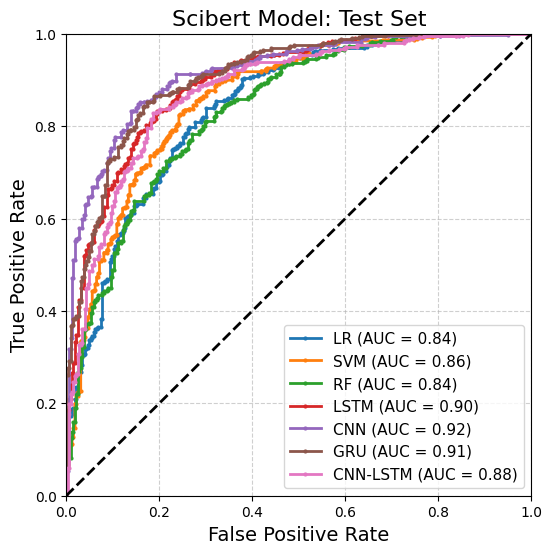

In [26]:
fpr, tpr, _ = roc_curve(validation_labels, lr_probs[:,1])
fpr2, tpr2, _ = roc_curve(validation_labels, svm_probs[:,1])
fpr3, tpr3, _ = roc_curve(validation_labels, rf_probs[:,1])
fpr4, tpr4, _ = roc_curve(validation_labels, lstm_probs)
fpr5, tpr5, _ = roc_curve(validation_labels, cnn_probs)
fpr6, tpr6, _ = roc_curve(validation_labels, gru_probs)
fpr7, tpr7, _ = roc_curve(validation_labels, lc_probs)

roc_auc1 = auc(fpr, tpr)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)
roc_auc4 = auc(fpr4, tpr4)
roc_auc5 = auc(fpr5, tpr5)
roc_auc6 = auc(fpr6, tpr6)
roc_auc7 = auc(fpr7, tpr7)

fprs = [fpr, fpr2, fpr3, fpr4, fpr5, fpr6, fpr7]
tprs = [tpr, tpr2, tpr3, tpr4, tpr5, tpr6, tpr7]
roc_aucs = [roc_auc1, roc_auc2, roc_auc3, roc_auc4, roc_auc5, roc_auc6, roc_auc7]
labels = ['LR', 'SVM', 'RF', 'LSTM', 'CNN', 'GRU', 'CNN-LSTM']

plt.figure(figsize=(6, 6))  

for fpr, tpr, roc_auc, label in zip(fprs, tprs, roc_aucs, labels):
    plt.plot(fpr, tpr, lw=2, label='{} (AUC = {:.2f})'.format(label, roc_auc), marker='.', markersize=4)  
    
plt.plot([0, 1], [0, 1], color='black', linestyle='--', lw=2)

plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Scibert Model: Test Set', fontsize=16)

plt.legend(loc='lower right', fontsize=11)

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.grid(True, linestyle='--', alpha=0.6)

plt.savefig(models_path + '/roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

In [27]:
#AUPRC curves

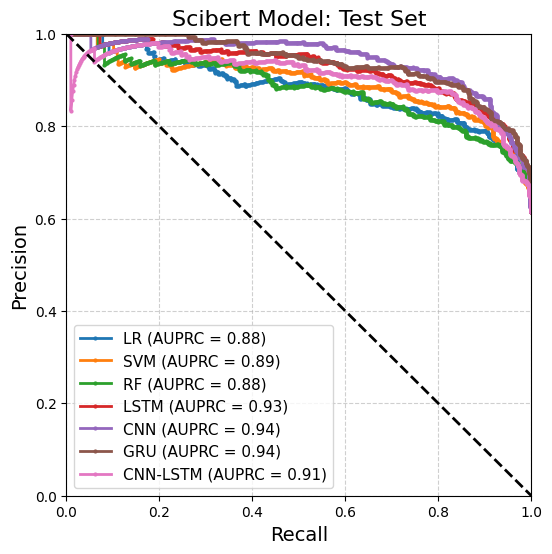

In [28]:
# Compute Precision-Recall curve for each model
precision1, recall1, _ = precision_recall_curve(validation_labels, lr_probs[:, 1])
precision2, recall2, _ = precision_recall_curve(validation_labels, svm_probs[:, 1])
precision3, recall3, _ = precision_recall_curve(validation_labels, rf_probs[:, 1])
precision4, recall4, _ = precision_recall_curve(validation_labels, lstm_probs)
precision5, recall5, _ = precision_recall_curve(validation_labels, cnn_probs)
precision6, recall6, _ = precision_recall_curve(validation_labels, gru_probs)
precision7, recall7, _ = precision_recall_curve(validation_labels, lc_probs)

# Calculate AUPRC
auprc1 = auc(recall1, precision1)
auprc2 = auc(recall2, precision2)
auprc3 = auc(recall3, precision3)
auprc4 = auc(recall4, precision4)
auprc5 = auc(recall5, precision5)
auprc6 = auc(recall6, precision6)
auprc7 = auc(recall7, precision7)

precisions = [precision1, precision2, precision3, precision4, precision5, precision6, precision7]
recalls = [recall1, recall2, recall3, recall4, recall5, recall6, recall7]
auprcs = [auprc1, auprc2, auprc3, auprc4, auprc5, auprc6, auprc7]
labels = ['LR', 'SVM', 'RF', 'LSTM', 'CNN', 'GRU', 'CNN-LSTM']

plt.figure(figsize=(6, 6))

for precision, recall, auprc, label in zip(precisions, recalls, auprcs, labels):
    plt.plot(recall, precision, lw=2, label='{} (AUPRC = {:.2f})'.format(label, auprc), marker='.', markersize=4)

plt.plot([0, 1], [1, 0], color='black', linestyle='--', lw=2)

plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Scibert Model: Test Set', fontsize=16)

plt.legend(loc='lower left', fontsize=11)

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.grid(True, linestyle='--', alpha=0.6)

plt.savefig(models_path + '/prc_curves.png', dpi=300, bbox_inches='tight')
plt.show()


In [29]:
# data table with score

In [30]:
dfs = []

# List of algorithm names and corresponding predictions
algorithm_names = ['LR', 'SVM', 'RF', 'LSTM', 'CNN', 'GRU', 'CNN-LSTM']
predictions = [lr_pred, svm_pred, rf_pred, lstm_pred, cnn_pred, gru_pred, lc_pred]

# Iterate over each algorithm and calculate scores
for name, pred in zip(algorithm_names, predictions):
    conf_matrix = confusion_matrix(validation_labels, pred)

    # Calculate metrics
    precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
    recall = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
    specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / conf_matrix.sum()
    f1 = 2 * (precision * recall) / (precision + recall)

    precision = round(precision, 3)
    recall = round(recall, 3)
    specificity = round(specificity, 3)
    accuracy = round(accuracy, 3)
    f1 = round(f1, 3)

    # Create a DataFrame for each algorithm
    df = pd.DataFrame({
        'Algorithm': [name],
        'Precision': [precision],
        'Recall': [recall],
        'Specificity': [specificity],
        'Accuracy': [accuracy],
        'F1 Score': [f1]
    })

    dfs.append(df)

scores_df = pd.concat(dfs, ignore_index=True)
scores_df.to_csv(models_path + '/scores_test.csv', index=False, sep='\t')

print(scores_df)

  Algorithm  Precision  Recall  Specificity  Accuracy  F1 Score
0        LR      0.783   0.906        0.602     0.789     0.840
1       SVM      0.800   0.906        0.640     0.803     0.850
2        RF      0.767   0.900        0.565     0.771     0.828
3      LSTM      0.880   0.802        0.826     0.812     0.839
4       CNN      0.860   0.910        0.764     0.854     0.884
5       GRU      0.816   0.914        0.674     0.821     0.862
6  CNN-LSTM      0.820   0.898        0.686     0.816     0.857


In [31]:
# evaluation set
unbias_set = pd.read_csv('data/manual_curation/eval.csv')
unbias_labels = unbias_set["LABEL"].values
unbias_sents = unbias_set["SENTENCE"]

tokenized_unbias_f = unbias_sents.apply((lambda x: tokenizer_f.encode(x, add_special_tokens=True)))

max_len = 0
for i in tokenized_unbias_f.values:
    if len(i) > max_len:
        max_len = len(i)

padded_unbias_f = np.array([i + [0]*(max_len-len(i)) for i in tokenized_unbias_f.values])
attention_mask_unbias_f = np.where(padded_unbias_f != 0, 1, 0)
input_ids_unbias_f = torch.tensor(padded_unbias_f)  
attention_mask_unbias_f = torch.tensor(attention_mask_unbias_f)

with torch.no_grad():
    last_hidden_states_unbias = model_f(input_ids_unbias_f, attention_mask=attention_mask_unbias_f)

features_unbias = last_hidden_states_unbias[0][:,0,:].numpy()


In [32]:
unbias_bert_features = last_hidden_states_unbias.last_hidden_state
unbias_bert_features_reshaped = tf.reshape(unbias_bert_features, (unbias_bert_features.shape[0], unbias_bert_features.shape[1], -1))
unbias_bert_features_reshaped = tf.convert_to_tensor(unbias_bert_features_reshaped, dtype=tf.float32)
unbias_labels = tf.convert_to_tensor(unbias_labels, dtype=tf.float32)

In [33]:
# evaluate on evaluation set

lr_pred_unbias = best_lr_model.predict_proba(features_unbias)
svm_pred_unbias = best_svm_model.predict_proba(features_unbias)
rf_pred_unbias = best_rf_model.predict_proba(features_unbias)
lstm_pred_unbias = best_lstm_model.predict(unbias_bert_features_reshaped)
cnn_pred_unbias = best_cnn_model.predict(unbias_bert_features_reshaped)
gru_pred_unbias = best_gru_model.predict(unbias_bert_features_reshaped)
lc_pred_unbias = best_lc_model.predict(unbias_bert_features_reshaped)


27/27 [==============================] - 1s 23ms/step


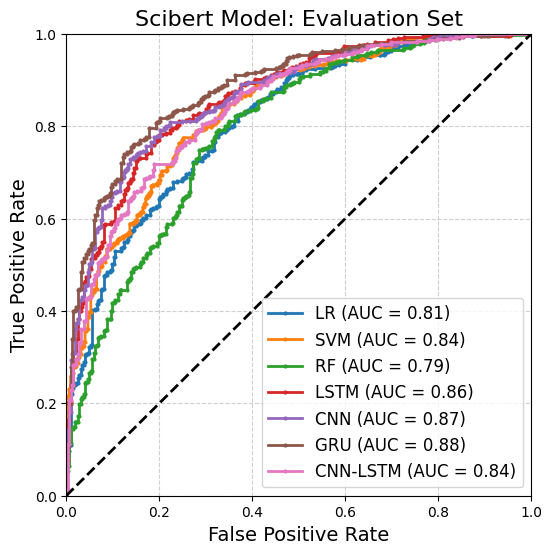

In [34]:
fpr, tpr, _ = roc_curve(unbias_labels, lr_pred_unbias[:,1])
fpr2, tpr2, _ = roc_curve(unbias_labels, svm_pred_unbias[:,1])
fpr3, tpr3, _ = roc_curve(unbias_labels, rf_pred_unbias[:,1])
fpr4, tpr4, _ = roc_curve(unbias_labels, lstm_pred_unbias)
fpr5, tpr5, _ = roc_curve(unbias_labels, cnn_pred_unbias)
fpr6, tpr6, _ = roc_curve(unbias_labels, gru_pred_unbias)
fpr7, tpr7, _ = roc_curve(unbias_labels, lc_pred_unbias)

# Calculate AUC 
roc_auc1 = auc(fpr, tpr)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)
roc_auc4 = auc(fpr4, tpr4)
roc_auc5 = auc(fpr5, tpr5)
roc_auc6 = auc(fpr6, tpr6)
roc_auc7 = auc(fpr7, tpr7)

fprs = [fpr, fpr2, fpr3, fpr4, fpr5, fpr6, fpr7]
tprs = [tpr, tpr2, tpr3, tpr4, tpr5, tpr6, tpr7]
roc_aucs = [roc_auc1, roc_auc2, roc_auc3, roc_auc4, roc_auc5, roc_auc6, roc_auc7]
labels = ['LR', 'SVM', 'RF', 'LSTM', 'CNN', 'GRU', 'CNN-LSTM']

plt.figure(figsize=(6, 6))  

for fpr, tpr, roc_auc, label in zip(fprs, tprs, roc_aucs, labels):
    plt.plot(fpr, tpr, lw=2, label='{} (AUC = {:.2f})'.format(label, roc_auc), marker='.', markersize=4)  
    
plt.plot([0, 1], [0, 1], color='black', linestyle='--', lw=2)

plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Scibert Model: Evaluation Set', fontsize=16)

plt.legend(loc='lower right', fontsize=12)

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.grid(True, linestyle='--', alpha=0.6)

plt.savefig(models_path + '/roc_curves_unbias.png', dpi=300, bbox_inches='tight')
plt.show()

In [35]:
#AUPRC curves

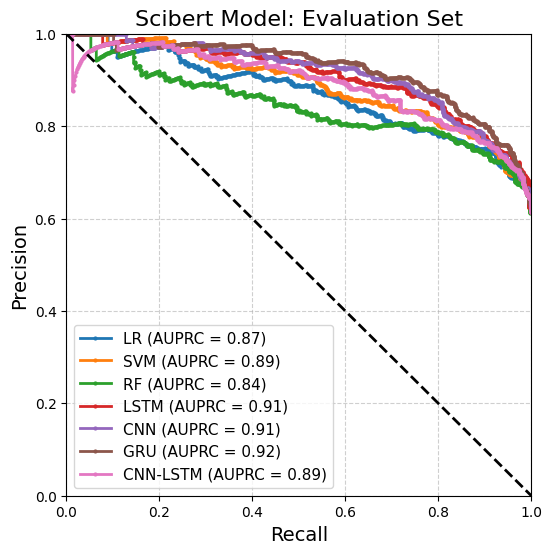

In [36]:
precision1, recall1, _ = precision_recall_curve(unbias_labels, lr_pred_unbias[:,1])
precision2, recall2, _ = precision_recall_curve(unbias_labels, svm_pred_unbias[:, 1])
precision3, recall3, _ = precision_recall_curve(unbias_labels, rf_pred_unbias[:, 1])
precision4, recall4, _ = precision_recall_curve(unbias_labels, lstm_pred_unbias)
precision5, recall5, _ = precision_recall_curve(unbias_labels, cnn_pred_unbias)
precision6, recall6, _ = precision_recall_curve(unbias_labels, gru_pred_unbias)
precision7, recall7, _ = precision_recall_curve(unbias_labels, lc_pred_unbias)

# Calculate AUPRC 
auprc1 = auc(recall1, precision1)
auprc2 = auc(recall2, precision2)
auprc3 = auc(recall3, precision3)
auprc4 = auc(recall4, precision4)
auprc5 = auc(recall5, precision5)
auprc6 = auc(recall6, precision6)
auprc7 = auc(recall7, precision7)

# Store the precision, recall, and AUPRC for each model
precisions = [precision1, precision2, precision3, precision4, precision5, precision6, precision7]
recalls = [recall1, recall2, recall3, recall4, recall5, recall6, recall7]
auprcs = [auprc1, auprc2, auprc3, auprc4, auprc5, auprc6, auprc7]
labels = ['LR', 'SVM', 'RF', 'LSTM', 'CNN', 'GRU', 'CNN-LSTM']

# Plotting AUPRC curves
plt.figure(figsize=(6, 6))

for precision, recall, auprc, label in zip(precisions, recalls, auprcs, labels):
    plt.plot(recall, precision, lw=2, label='{} (AUPRC = {:.2f})'.format(label, auprc), marker='.', markersize=4)

plt.plot([0, 1], [1, 0], color='black', linestyle='--', lw=2)

plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Scibert Model: Evaluation Set', fontsize=16)

plt.legend(loc='lower left', fontsize=11)

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.grid(True, linestyle='--', alpha=0.6)

plt.savefig(models_path + '/prc_curves_unbias.png', dpi=300, bbox_inches='tight')
plt.show()


In [37]:
# Calculate all metrics

In [38]:
dfs = []

algorithm_names = ['LR', 'SVM', 'RF', 'LSTM', 'CNN', 'GRU', 'CNN-LSTM']
predictions = [np.round(lr_pred_unbias[:,1]), np.round(svm_pred_unbias[:,1]), np.round(rf_pred_unbias[:,1])
               , np.round(lstm_pred_unbias), np.round(cnn_pred_unbias), np.round(gru_pred_unbias), np.round(lc_pred_unbias)]

# Iterate over each algorithm and calculate scores
for name, pred in zip(algorithm_names, predictions):
    conf_matrix = confusion_matrix(unbias_labels, pred)

    precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
    recall = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
    specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    accuracy = (conf_matrix[0, 0] + conf_matrix[1, 1]) / conf_matrix.sum()
    f1 = 2 * (precision * recall) / (precision + recall)

    precision = round(precision, 3)
    recall = round(recall, 3)
    specificity = round(specificity, 3)
    accuracy = round(accuracy, 3)
    f1 = round(f1, 3)

    # Create a DataFrame for each algorithm
    df = pd.DataFrame({
        'Algorithm': [name],
        'Precision': [precision],
        'Recall': [recall],
        'Specificity': [specificity],
        'Accuracy': [accuracy],
        'F1 Score': [f1]
    })

    # Append the DataFrame to the list
    dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
scores_df = pd.concat(dfs, ignore_index=True)
scores_df.to_csv(models_path + '/scores_unbias.csv', index=False, sep='\t')

print(scores_df)

  Algorithm  Precision  Recall  Specificity  Accuracy  F1 Score
0        LR      0.750   0.894        0.528     0.753     0.816
1       SVM      0.775   0.883        0.593     0.771     0.825
2        RF      0.745   0.890        0.516     0.745     0.811
3      LSTM      0.840   0.812        0.755     0.790     0.826
4       CNN      0.787   0.890        0.618     0.785     0.836
5       GRU      0.781   0.916        0.593     0.791     0.843
6  CNN-LSTM      0.781   0.873        0.612     0.772     0.824


In [39]:
#Plot losses

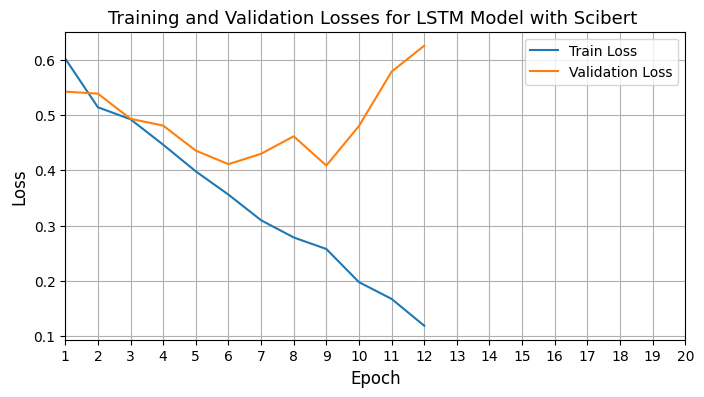

In [40]:
# Load the CSV file
df = pd.read_csv(models_path + "/best_fold_lstm_losses.csv")
# Plot the losses
plt.figure(figsize=(8, 4))

# Plot the training loss
plt.plot(df.index + 1, df["Train Loss"], label="Train Loss")

# Plot the validation loss
plt.plot(df.index + 1, df["Validation Loss"], label="Validation Loss")

# Set the x-axis limits
plt.xlim(1, 20)
plt.xticks(range(1, 21))  
plt.xlabel("Epoch", size=12)
plt.ylabel("Loss", size=12)
plt.title("Training and Validation Losses for LSTM Model with Scibert ", size=13)
plt.legend()
plt.grid(True)

# Save the plot
plt.savefig(models_path + "/lstm_loss_plot.png", dpi=300)
plt.show()


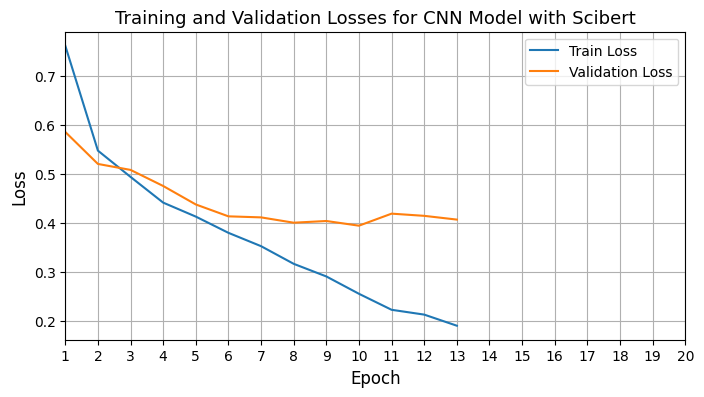

In [41]:
# Load the CSV file
df = pd.read_csv(models_path + "/best_fold_cnn_losses.csv")
plt.figure(figsize=(8, 4))

plt.plot(df.index + 1, df["Train Loss"], label="Train Loss")

plt.plot(df.index + 1, df["Validation Loss"], label="Validation Loss")

plt.xlim(1, 20)
plt.xticks(range(1, 21))  

plt.xlabel("Epoch", size=12)
plt.ylabel("Loss", size=12)
plt.title("Training and Validation Losses for CNN Model with Scibert", size=13)
plt.legend()
plt.grid(True)

plt.savefig(models_path + "/cnn_loss_plot.png", dpi=300)
plt.show()


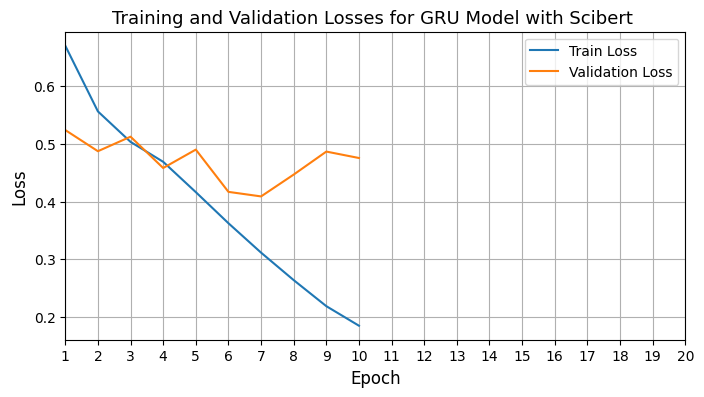

In [42]:
df = pd.read_csv(models_path + "/best_fold_gru_losses.csv")
plt.figure(figsize=(8, 4))

plt.plot(df.index + 1, df["Train Loss"], label="Train Loss")

plt.plot(df.index + 1, df["Validation Loss"], label="Validation Loss")

plt.xlim(1, 20)
plt.xticks(range(1, 21))  

plt.xlabel("Epoch", size=12)
plt.ylabel("Loss", size=12)
plt.title("Training and Validation Losses for GRU Model with Scibert ", size=13)
plt.legend()
plt.grid(True)

plt.savefig(models_path + "/gru_loss_plot.png", dpi=300)

plt.show()

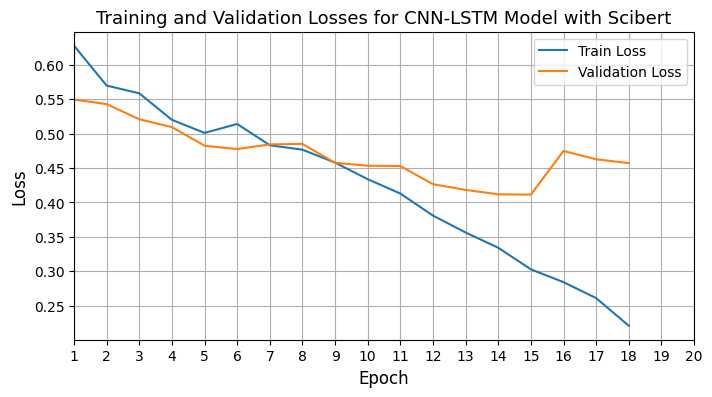

In [43]:
df = pd.read_csv(models_path + "/best_fold_cnn_lstm_losses.csv")
plt.figure(figsize=(8, 4))

plt.plot(df.index + 1, df["Train Loss"], label="Train Loss")

plt.plot(df.index + 1, df["Validation Loss"], label="Validation Loss")

plt.xlim(1, 10)
plt.xticks(range(1, 21))  

plt.xlabel("Epoch", size=12)
plt.ylabel("Loss", size=12)
plt.title("Training and Validation Losses for CNN-LSTM Model with Scibert", size=13)
plt.legend()
plt.grid(True)

plt.savefig(models_path + "/cnn_lstm_loss_plot.png", dpi=300)

plt.show()